# Step 1: Understand the dataset 

1. Number of null columns : 0

2. Range of dates in the dataset 1/1/2011 - 9/9/2015

3. Number of unique customers : 1000

4. Standard descriptive statistics for the Amount field
count    4186.000000
mean        9.028082
std        38.723909
min        -1.000000
25%         3.310000
50%         6.885000
75%        11.690000
max      2033.000000
Name: Amount, dtype: float64

 Trend in transaction amount over a period of next months


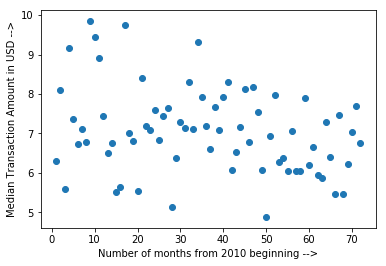

In [205]:
import pandas as pd
import matplotlib.pyplot as plt


clv_transactions = pd.read_csv('HW1 clv_transactions.csv')
clv_transactions.head()

null_columns = clv_transactions.columns[clv_transactions.isnull().any()]
print('1. Number of null columns : ' + str(len(null_columns)))

min_transaction_date = clv_transactions['TransactionDate'].min()
max_transaction_date = clv_transactions['TransactionDate'].max()

print('\n2. Range of dates in the dataset ' + min_transaction_date + ' - ' + max_transaction_date)

print('\n3. Number of unique customers : ' + str(clv_transactions['CustomerID'].nunique()))

print('\n4. Standard descriptive statistics for the Amount field')

print(clv_transactions['Amount'].describe())

print('\n Trend in transaction amount over a period of next months')
clv_transactions['TransactionDate'] = pd.to_datetime(clv_transactions['TransactionDate'])

y = clv_transactions['Amount'].groupby([clv_transactions['TransactionDate'].dt.year,clv_transactions['TransactionDate'].dt.month]).median()

x= pd.DataFrame({ '' : range(1, 72 + 1 ,1)})
plt.xlabel("Number of months from 2010 beginning -->")
plt.ylabel("Median Transaction Amount in USD -->")
plt.scatter(x,y)


 Trend in transaction amount over a period of next years


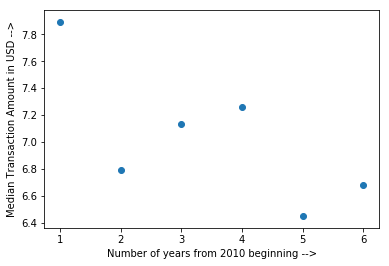

In [206]:
print('\n Trend in transaction amount over a period of next years')

y = clv_transactions['Amount'].groupby([clv_transactions['TransactionDate'].dt.year]).median()

x = pd.DataFrame({ '' : range(1, 6 + 1 ,1)})
plt.xlabel("Number of years from 2010 beginning -->")
plt.ylabel("Median Transaction Amount in USD -->")
plt.scatter(x,y)


There is no general increase in the transaction amounts over time. Though there is an increase in median transaction amounts from 2011 to 2013, but overall, there is no general trend.

# Step 2: Explore the dataset

In [174]:
#Step 2

Q1 = clv_transactions['Amount'].quantile(0.25)
Q3 = clv_transactions['Amount'].quantile(0.75)
IQR = Q3 - Q1

clv_trans = clv_transactions[~((clv_transactions['Amount'] < (Q1 - 3.5 * IQR)) |(clv_transactions['Amount'] > (Q3 + 3.5 * IQR)))]
clv_trans_outliers = clv_transactions[((clv_transactions['Amount'] < (Q1 - 3.5 * IQR)) |(clv_transactions['Amount'] > (Q3 + 3.5 * IQR)))]

print('These are the outlier points based on the points which are very farther away(using interquartile ranges and box plot) : ')
clv_trans_outliers

These are the outlier points based on the points which are very farther away(using interquartile ranges and box plot) : 


,TransactionID,TransactionDate,CustomerID,Amount
23,24,2011-10-07,7,1003.0
211,212,2014-05-14,54,1027.0
4177,4178,2012-08-13,1000,2033.0


# Step 3: Determine origin year of customers

In [179]:
#Step 3

clv_transactions = clv_trans.copy()
clv_transactions['TransactionDate'] = pd.to_datetime(clv_transactions['TransactionDate'])

origin_transaction_year = clv_transactions['TransactionDate'].dt.year.groupby(clv_transactions['CustomerID']).min()
origin_year_df = pd.DataFrame(origin_transaction_year)
origin_year_df.reset_index(level=0, inplace=True)
origin_year_df['OriginYear'] = origin_year_df['TransactionDate']
origin_year_df = origin_year_df.drop(columns=['TransactionDate'])

clv_transactions['TransactionYear'] = clv_transactions['TransactionDate'].dt.year
clv_transactions = clv_transactions.merge(origin_year_df, on='CustomerID')
clv_transactions.head()


,TransactionID,TransactionDate,CustomerID,Amount,TransactionYear,OriginYear
0,1,2012-09-04,1,20.26,2012,2012
1,2,2012-05-15,2,10.87,2012,2012
2,3,2014-05-23,2,2.21,2014,2012
3,4,2014-10-24,2,10.48,2014,2012
4,5,2012-10-13,2,3.94,2012,2012


# Step 4: Calculate cumulative transaction amounts

In [197]:
#Step 4
df_clv_transactions = clv_transactions.groupby(['OriginYear','TransactionYear'])[['Amount']].sum()

df_clv_transactions = df_clv_transactions.reset_index() 
df_clv_transactions1 = df_clv_transactions

def getting_cumulative_transactions(months):
    trans = df_clv_transactions1[df_clv_transactions1['TransactionYear']==(df_clv_transactions1['OriginYear'] -1+months//12)]['Amount']
    df_clv_transactions_merged = trans.reset_index()
    df_clv_transactions_merged = df_clv_transactions_merged.drop(columns=['index'])
    df_clv_transactions_merged.rename(columns = {"Amount":months},inplace=True)
    return df_clv_transactions_merged

df_clv_transactions_merged = getting_cumulative_transactions(12)
df_clv_transactions_merged2 = getting_cumulative_transactions(24)
df_clv_transactions_merged3 = getting_cumulative_transactions(36)
df_clv_transactions_merged4 = getting_cumulative_transactions(48)
df_clv_transactions_merged5 = getting_cumulative_transactions(60)
df_clv_transactions_merged6 = getting_cumulative_transactions(72)

df_merged = pd.concat([df_clv_transactions_merged,df_clv_transactions_merged2,df_clv_transactions_merged3,df_clv_transactions_merged4,df_clv_transactions_merged5,df_clv_transactions_merged6], axis=1)
df_merged.index = ['2010-01-01–2010-12-31','2011-01-01-2011-12-31','2012-01-01–2012-12-31','2013-01-01–2013-12-31','2014-01-01–2014-12-31','2015-01-01–2015-12-31']
df_merged.index.name = 'Origin'
df_merged = df_merged.cumsum(axis=1)
df_merged = df_merged.fillna(0)
df_merged

,12,24,36,48,60,72
Origin,,,,,,
2010-01-01–2010-12-31,2259.67,3614.78,5274.81,6632.37,7930.69,8964.49
2011-01-01-2011-12-31,2238.46,3756.90,5464.99,6702.11,7861.24,0.00
2012-01-01–2012-12-31,2181.35,3874.69,5226.86,6501.85,0.00,0.00
2013-01-01–2013-12-31,2179.85,3608.81,5226.75,0.00,0.00,0.00
2014-01-01–2014-12-31,1830.85,3262.05,0.00,0.00,0.00,0.00
2015-01-01–2015-12-31,1912.17,0.00,0.00,0.00,0.00,0.00


# Step 5: Calculate cumulative transaction amounts 

In [193]:
#Step 5

total_customers = clv_transactions[clv_transactions['OriginYear'] == clv_transactions['TransactionYear']]
total_customers = total_customers.groupby(['CustomerID','OriginYear'])[['Amount']].count()
total_customers.index.name = ['Origin']
total_customers.rename(columns = {'OriginYear':'Count'})

total_customers = total_customers.groupby(['OriginYear'])['Amount'].count()
total_customers = pd.DataFrame(total_customers)

for i in range(1,7):
    a = []
    for j in range(0,7-i):
        a.append(total_customers['Amount'][2010 + (j)])
    for j in range(7-i,6):
        a.append(0)
    total_customers[12*(i)] = a
total_customers = total_customers.drop(columns = ['Amount'])           
total_customers.index = ['2010-01-01–2010-12-31','2011-01-01-2011-12-31','2012-01-01–2012-12-31','2013-01-01–2013-12-31','2014-01-01–2014-12-31','2015-01-01–2015-12-31']
total_customers.index.name = 'Origin'

total_customers

,12,24,36,48,60,72
Origin,,,,,,
2010-01-01–2010-12-31,172,172,172,172,172,172
2011-01-01-2011-12-31,170,170,170,170,170,0
2012-01-01–2012-12-31,163,163,163,163,0,0
2013-01-01–2013-12-31,180,180,180,0,0,0
2014-01-01–2014-12-31,155,155,0,0,0,0
2015-01-01–2015-12-31,160,0,0,0,0,0


# Step 6: Historic CLV 

In [194]:
# Step 6
clv = df_merged/total_customers
# clv.round(2)
clv.fillna(0)

,12,24,36,48,60,72
Origin,,,,,,
2010-01-01–2010-12-31,13.137616,21.016163,30.667500,38.560291,46.108663,52.119128
2011-01-01-2011-12-31,13.167412,22.099412,32.147000,39.424176,46.242588,0.000000
2012-01-01–2012-12-31,13.382515,23.771104,32.066626,39.888650,0.000000,0.000000
2013-01-01–2013-12-31,12.110278,20.048944,29.037500,0.000000,0.000000,0.000000
2014-01-01–2014-12-31,11.811935,21.045484,0.000000,0.000000,0.000000,0.000000
2015-01-01–2015-12-31,11.951062,0.000000,0.000000,0.000000,0.000000,0.000000


Text(0, 0.5, 'HistoricCLV')

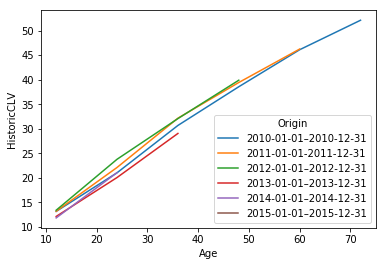

In [203]:
line_plot = clv.transpose().plot.line()
line_plot.set_xlabel('Age')
line_plot.set_ylabel('HistoricCLV')

# Step 7: Interpreting your results 

In [204]:
x= df_merged.cumsum()
y= total_customers.cumsum()
interpretation = (x.iloc[-1]/y.iloc[-1]).round(2)
interpretation

12    12.60
24    21.57
36    30.94
48    39.28
60    46.18
72    52.12
Name: 2015-01-01–2015-12-31, dtype: float64

a) Customers acquired in 2011 have spent $8964 till date.
b) Each group of customers exhibit similar patterns of spending. Lower bound on CLV over a period of 6 years is $52 which increases by around $7-$9 every year. So, the cost taken to acquire a customer should be less than the lower bound for the company to be profitable. Hence, according to the above interpreation, the company should not spend on an average more than $12 for the first year and around $7-$9 on every customer to stay profitable.